In [1]:
!nvidia-smi

Wed Aug 19 18:16:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install transformers

     |████████████████████████████████| 778kB 4.7MB/s 
     |████████████████████████████████| 3.0MB 23.8MB/s 
     |████████████████████████████████| 1.1MB 58.7MB/s 
     |████████████████████████████████| 890kB 55.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=339e6020c75c98969328eb188d1c2011bd89e0525d8dba916c44e5d32823c747
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [4]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [5]:
import numpy as np
import pandas as pd
import torch
import transformers as ppb # pytorch transformers
from sklearn.model_selection import train_test_split

In [7]:
df = pd.read_csv("/content/drive/My Drive/Dataset_all.csv", encoding = "big5")
df.head()

,情境,標籤
0,我前陣子在掏寶網購商品，今天收到貨了,0
1,前陣子我有多益報名，今天收到准考證,0
2,今天早上掏寶通知我說重複訂購,0
3,今天早上收到貨運公司通知說有代收包裹,0
4,昨天收到全國繳費網的繳費通知,0


In [8]:
#宣告 DistilBert
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

In [9]:
# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [10]:
tokenized = df["情境"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [11]:
tokenized.head()

0    [101, 1855, 1776, 100, 1816, 100, 100, 100, 10...
1    [101, 1776, 100, 1816, 1855, 1873, 100, 100, 1...
2    [101, 100, 1811, 100, 1742, 100, 100, 100, 100...
3    [101, 100, 1811, 100, 1742, 100, 100, 100, 100...
4    [101, 100, 1811, 100, 100, 100, 1800, 100, 100...
Name: 情境, dtype: object

In [12]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [13]:
attention_mask = np.where(padded != 0, 1, 0)

In [14]:
input_ids = torch.tensor(padded).to(torch.int64)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [15]:
features = last_hidden_states[0][:,0,:].numpy()

In [16]:
labels = df["標籤"]

In [17]:
X_tr = np.array(features)
y_tr = np.array(labels)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_tr, y_tr, test_size=0.2, random_state=0)

In [19]:
import keras
import keras.utils
from keras.utils import to_categorical
y_train = keras.utils.to_categorical(y_train, 8)
y_test = keras.utils.to_categorical(y_test,8)

Using TensorFlow backend.


In [20]:
# Function to create model, required for KerasClassifier
def create_model(activation='relu'):
    # create model
    model = Sequential()
    model.add(Dense(768, activation=activation, input_shape=(768,)))
    model.add(Dense(768, activation=activation))
    model.add(Dense(8, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [23]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_model, epochs=500, batch_size=128, verbose=1)

In [24]:
distilbertNN = model.fit(X_train, y_train, batch_size=128, epochs=50, validation_data=(X_test, y_test))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train on 1827 samples, validate on 457 samples
Epoch 1/50
1827/1827 [==============================] - 2s 961us/step - loss: 1.2126 - accuracy: 0.4193 - val_loss: 1.0451 - val_accuracy: 0.3195
Epoch 2/50
1827/1827 [==============================] - 0s 36us/step - loss: 0.8897 - accuracy: 0.6251 - val_loss: 0.7531 - val_accuracy: 0.7221
Epoch 3/50
1827/1827 [==============================] - 0s 36us/step - loss: 0.6686 - accuracy: 0.7510 - val_loss: 0.6013 - val_accuracy: 0.7943
Epoch 4/50
1827/1827 [==============================] - 0s 38us/step - loss: 0.4909 - accuracy: 0.8166 - val_loss: 0.4456 - val_accuracy: 0.8009
Epoch 5/50
1827/1827 [==============================] - 0s 39us/step - loss: 0.4045 - accuracy: 0.8435 - val_loss: 0.3710 - val_accuracy: 0.8512
Epoch 6/50
1827/1827 [==============================] - 0s 36us/step - loss: 0.3650 - accuracy: 0.8588 - val_loss: 0.2844 - val_accuracy: 0.9103


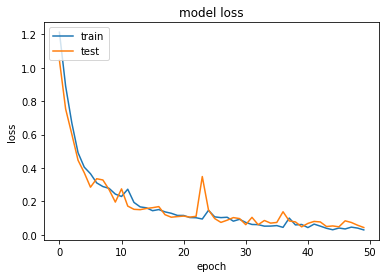

In [27]:
import matplotlib.pyplot as plt

plt.plot(distilbertNN.history['loss'])
plt.plot(distilbertNN.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()